# Illustrate the iEGM through a unitary model

## Monte Carlo Settings

In [1]:
MC_num = 2 #200 # number of Monte Carlo simulations
C_num_grid = (25,50,75,100,200) # number of grid points in consumption grid i iEGM
do_print = True # whether to print results during Monte Carlo iterations

common_specs = { # common specifications across methods
    # 'rho':1.5,      # constant relative risk aversion coefficient

    'num_m':100,    # number of points in the single state: normalized resources
    'max_m':5.0,    # maximum level of normalized resources

    'max_C':10.0,   # maximum level of consumption in iEGM precomputation

    'T': 20,        # number of periods
    'simN':10_000,  # number of agents in simulation

} 

## Load relevant packages

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
from time import time
import matplotlib.pyplot as plt
from UnitaryModel import UnitaryModelClass

plt.rcParams.update({'font.size': 14})

## Illustrate the pre-computation of consumption interpolator

In [3]:
# load local model file and initialize model class
SAVE = True
specs_illustrate = {
    'rho_w':1.5,
    
    'restricted_model':False,

    'num_C':10,
    'max_C':5.0,
    'unequal_C':1.5,
    
    'precompute_intra':True,
}

model = UnitaryModelClass(par=specs_illustrate)
par = model.par

# pre-compute consumption
model.precompute_C()

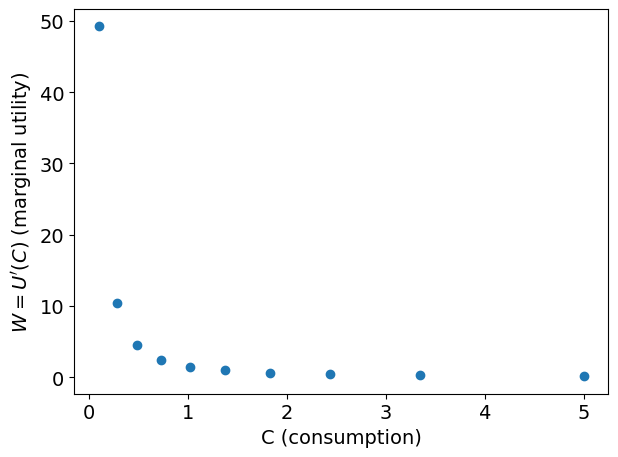

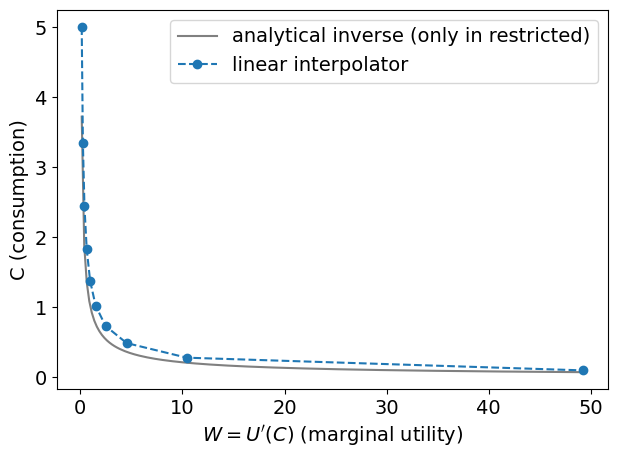

In [4]:
# illustrate the iEGM pre-computation
fig, ax = plt.subplots()
ax.scatter(par.grid_C,par.grid_marg_U)
ax.set(xlabel='C (consumption)',ylabel="$W=U\'(C)$ (marginal utility)");
fig.tight_layout()

fig, ax = plt.subplots()
fine_grid = np.linspace(par.grid_marg_U_flip[0],par.grid_marg_U_flip[-1],200)
ax.plot(fine_grid,model.inv_marg_HH_util(fine_grid),color='gray',label='analytical inverse (only in restricted)')
ax.plot(par.grid_marg_U_flip,par.grid_C_flip,marker='o',linestyle='--',color='tab:blue',label='linear interpolator');
ax.set(xlabel='$W=U\'(C)$ (marginal utility)',ylabel="C (consumption)");
ax.legend();
fig.tight_layout()

## Solve the "true" model using many grid points in VFI

In [5]:
specs_true = {
    'method':'vfi',
    
    'num_m':1000,
    'max_m':20.0,
}
model_true = UnitaryModelClass(par=specs_true)
%time model_true.solve()
%time model_true.simulate()

model_true_restricted = UnitaryModelClass(par={**specs_true,'restricted_model':True})
%time model_true_restricted.solve()
%time model_true_restricted.simulate()

CPU times: total: 6min 59s
Wall time: 6min 59s
CPU times: total: 15.6 ms
Wall time: 25.2 ms
CPU times: total: 28.1 s
Wall time: 28.1 s
CPU times: total: 31.2 ms
Wall time: 24.5 ms


## Accuracy measures

In [6]:
grid_m_MSE = np.linspace(0.5,5.0,100) # points to evaluatre the consumption function

# interpolator of household utility. This is to simulate lifetime utility without having to resolve the model many times
C_grid = np.linspace(model_true.par.grid_C[0],model_true.par.grid_C[-1],300)
HH_util_grid = np.nan + np.ones(len(C_grid))
for i,C in enumerate(C_grid):
    HH_util_grid[i] = model_true.HH_util(C,recalculate=True)
HH_util = {'C_grid':C_grid,'HH_util_grid':HH_util_grid}

HH_util_grid_restr = np.nan + np.ones(len(C_grid))
for i,C in enumerate(C_grid):
    HH_util_grid_restr[i] = model_true_restricted.HH_util(C,recalculate=True)
HH_util_restr = {'C_grid':C_grid,'HH_util_grid':HH_util_grid_restr}

# calcualte lifetime utility in true model
model_true.lifetime_utility(HH_util) 
model_true_restricted.lifetime_utility(HH_util_restr)

In [7]:
common_specs = {
    'num_m': 40,
    'num_C':30,
}



In [ ]:
model_specs = {    
    'vfi': {'method':'vfi','table_name':'VFI'},
    # 'vfi (simul)': {'method':'vfi_simul','table_name':'VFI (simul.)'},
    'egm': {'method':'egm','table_name':'EGM'},
    'iegm (num)': {'method':'iegm','interp_method':'numerical','precompute_intra':False,'table_name':'EGM (num)'}, # note that if we do not precopute the Marg_HH_util, this is super slow
    'iegm': {'method':'iegm','interp_method':'linear','precompute_intra':True,'table_name':'iEGM'},
}

model_specs_pre = {    
    'vfi, pre': {'method':'vfi','precompute_E':True,'table_name':'VFI, pre E'},
    'vfi, pre all': {'method':'vfi','precompute_E':True,'precompute_intra':True,'table_name':'VFI, pre E + intra'},
    'vfi (simul), pre': {'method':'vfi_simul','precompute_E':True,'table_name':'VFI (simul.), pre E'},
    'egm, pre': {'method':'egm','precompute_E':True,'table_name':'EGM, pre E'},
    'iegm (num), pre': {'method':'iegm','interp_method':'numerical','precompute_E':True,'precompute_intra':False,'table_name':'EGM (num), pre E'}, # note that if we do not precopute the Marg_HH_util, this is super slow
    'iegm (num), pre all': {'method':'iegm','interp_method':'numerical','precompute_E':True,'precompute_intra':True,'table_name':'EGM (num), pre E + intra'}, # note that if we do not precopute the Marg_HH_util, this is super slow
    'iegm, pre': {'method':'iegm','interp_method':'linear','precompute_E':True,'precompute_intra':True,'table_name':'iEGM, pre E + intra'},
}

In [9]:
models = {}
results = {}
for restricted in [True,False]:
    for name_base,specs in {**model_specs, **model_specs_pre}.items():
        
        
        if ('iegm' in name_base) and (specs['interp_method']!='numerical'):
            C_num_grid_now = C_num_grid
        else:
            C_num_grid_now = (20,) # not used
        
        for num_C in C_num_grid_now:  
            restricted_str = 'restricted' if restricted else 'unrestricted'
            name = name_base + (f' num_C={num_C}' if len(C_num_grid_now)>1 else '')
            key = (restricted_str,num_C) if len(C_num_grid_now)>1 else restricted_str
            
            if name not in results:
                results[name] = {}
            results[name][key] = {
                'timing':np.nan+np.ones(MC_num),
                'timing_rel':np.nan+np.ones(MC_num),
                'MSE':np.nan+np.ones(MC_num),
                'MAD':np.nan+np.ones(MC_num),
                'util_diff_pct':np.nan+np.ones(MC_num),
                'comp':np.nan+np.ones(MC_num),
            } 
            
            if (not restricted) & (('egm' == name_base) | ('egm, pre' == name_base)):
                continue # skip unrestricted EGM since it is not available for this model
            if (restricted) & ('vfi (simul)' in name_base):
                continue # skip restricted VFI simul since closed form used here
            
            if do_print: print(name,key)
            model_name = name + '_restricted' if restricted else name
            # setup model and solution containers
            models[model_name] = UnitaryModelClass(par={**common_specs,**specs,'num_C':num_C,'restricted_model':restricted})
            
            # loop over Monte Carlo iterations
            for i_mc in range(MC_num):
                if do_print: print(f'{i_mc+1}/{MC_num} running...')
                
                # re-simulate true model for this Monte Carlo iteration to get new draws
                true = model_true_restricted if 'restricted' in name_base else model_true
                util = HH_util_restr if 'restricted' in name_base else HH_util
                
                true.par.seed = i_mc
                true.allocate_draws()
                true.simulate()
                true.lifetime_utility(util) 
                
                # solution time
                t0 = time()
                models[model_name].solve()
                secs = time() - t0
                if do_print: print(f'Solution time: {secs:.2f} seconds')
                
                # accuracy
                MSE,MAD = models[model_name].MSE_consumption(true,grid_m_MSE)
                if do_print: print(f'MSE in consumption function: {MSE:.4f}')
                if do_print: print(f'MAD in consumption function: {MAD:.4f}')
                
                models[model_name].par.seed = i_mc
                models[model_name].allocate_draws()
                models[model_name].simulate()
                
                diff_pct = models[model_name].lifetime_utility(util,true)
                if do_print: print(f'Difference in lifetime utility (compared to true model): {diff_pct:.4f}')
                
                comp = models[model_name].wealth_compensation(util,true)
                if do_print: print(f'Wealth compensation (pct of household exp. income): {comp:.4f}',end='\n\n')
                
                results[name][key]['timing'][i_mc] = secs
                results[name][key]['timing_rel'][i_mc] = secs/results['vfi'][restricted_str]['timing'][i_mc]
                results[name][key]['MSE'][i_mc] = MSE
                results[name][key]['MAD'][i_mc] = MAD
                results[name][key]['util_diff_pct'][i_mc] = diff_pct
                results[name][key]['comp'][i_mc] = comp

vfi restricted
1/2 running...
Solution time: 1.22 seconds
MSE in consumption function: 0.0003
MAD in consumption function: 0.0150
Difference in lifetime utility (compared to true model): 0.0029
Wealth compensation (pct of household exp. income): 0.2724

2/2 running...
Solution time: 1.19 seconds
MSE in consumption function: 0.0003
MAD in consumption function: 0.0150
Difference in lifetime utility (compared to true model): 0.0028
Wealth compensation (pct of household exp. income): 0.2651

egm restricted
1/2 running...
Solution time: 0.08 seconds
MSE in consumption function: 0.0003
MAD in consumption function: 0.0135
Difference in lifetime utility (compared to true model): 0.0032
Wealth compensation (pct of household exp. income): 0.3016

2/2 running...
Solution time: 0.09 seconds
MSE in consumption function: 0.0003
MAD in consumption function: 0.0135
Difference in lifetime utility (compared to true model): 0.0031
Wealth compensation (pct of household exp. income): 0.2968

iegm (num) res

In [ ]:
# write to latex file
do_both_pre = False # whether to include the restricted model in the pre-computed verions
table_path = 'output/MC_unitary'
output = ('timing','timing_rel','MAD','comp')
output_labels = '& time (s) & rel. & MAD(C)  & Comp(A) '

num_cols_per_model = len(output)

for pre in (False,True):
    pre_str = ', pre' if pre else ''
    tab_name = table_path + '_pre' if pre else table_path
    
    num_models = 1 if pre & (not do_both_pre) else 2
    num_cols = 2 + num_cols_per_model*num_models
    
    with open(tab_name+'.tex','w') as f:
        # table head
        f.write('\\begin{tabular}{ll' + 'c'* (num_cols-2) + '} \\toprule\n')
        if num_models==2:
            f.write(f'&& \\multicolumn{{{num_cols_per_model}}}{{c}}{{Restricted model}} & \\multicolumn{{{num_cols_per_model}}}{{c}}{{Unrestricted model}} \\\\ \n ')
            f.write(f'\\cmidrule(lr){{3-{2+num_cols_per_model}}} \\cmidrule(lr){{{3+num_cols_per_model}-{num_cols}}} &')
        else:
            f.write(f'&& \\multicolumn{{{num_cols_per_model}}}{{c}}{{Unrestricted model}}  \\\\ \n ')
            f.write(f'\\cmidrule(lr){{3-{2+num_cols_per_model}}} &')
        for _ in range(num_models): f.write(output_labels)
        f.write('\\\\ \\midrule \n')
        
        # table body
        model_specs_now = model_specs_pre if pre else model_specs
        for name_base,specs in model_specs_now.items():
            table_name = specs['table_name']
            
            if ('iegm' in name_base) and (specs['interp_method']!='numerical'):
                C_num_grid_now = C_num_grid
            else:
                C_num_grid_now = (20,) # not used
            
            #num_multi = 1 if len(C_num_grid_now)>1 else 2
            f.write(f'\\multicolumn{{{2}}}{{l}}{{{table_name}}} ')
            for iC,num_C in enumerate(C_num_grid_now):  
                if len(C_num_grid_now)>1:
                    if iC==0: # skip entire row
                        f.write(f'\\multicolumn{{{num_cols-2}}}{{c}}{{}} \\\\ \n')
                    
                    f.write(f'& $\\#_C$={num_C}')
                
                for restricted in [True,False]:
                    if (num_models==1) and restricted:
                        continue
                    name = name_base + (f' num_C={num_C}' if len(C_num_grid_now)>1 else '')
                    restricted_str = 'restricted' if restricted else 'unrestricted'
                    key = (restricted_str,num_C) if len(C_num_grid_now)>1 else restricted_str
                    
                    for out in output:
                        avg = np.mean(results[name][key][out])
                        if np.isnan(avg):
                            f.write('& N.A. ')
                        else:
                            f.write(f'& {avg:.3f} ')
                f.write('\\\\ \n')
        f.write('\\bottomrule \\end{tabular}\n')
        
        
    # output the table here by looping through all lines in the file and printing them
    with open(tab_name+'.tex','r') as f:
        for line in f:
            print(line,end='')  



\begin{tabular}{llcccccccc} \toprule
&& \multicolumn{4}{c}{Restricted model} & \multicolumn{4}{c}{Unrestricted model} \\ 
 \cmidrule(lr){3-6} \cmidrule(lr){7-10} && time (s) & rel. & MAD(C)  & Comp.(A) & time (s) & rel. & MAD(C)  & Comp.(A) \\ \midrule 
\multicolumn{2}{l}{VFI} & 1.206 & 1.000 & 0.015 & 0.269 & 18.844 & 1.000 & 0.004 & 0.047 \\ 
\multicolumn{2}{l}{VFI (simul.)} & N.A. & N.A. & N.A. & N.A. & 8.749 & 0.464 & 0.004 & 0.048 \\ 
\multicolumn{2}{l}{EGM} & 0.086 & 0.071 & 0.013 & 0.299 & N.A. & N.A. & N.A. & N.A. \\ 
\multicolumn{2}{l}{EGMnum} & 0.114 & 0.094 & 0.013 & 0.299 & 163.477 & 8.671 & 0.001 & 0.000 \\ 
\multicolumn{2}{l}{iEGM} \multicolumn{8}{c}{} \\ 
& $\#_C$=25& 0.077 & 0.064 & 0.218 & 62.790 & 0.259 & 0.014 & 0.013 & 0.152 \\ 
& $\#_C$=50& 0.086 & 0.071 & 0.064 & 7.242 & 0.427 & 0.023 & 0.003 & 0.000 \\ 
& $\#_C$=75& 0.088 & 0.073 & 0.039 & 2.082 & 0.612 & 0.032 & 0.002 & 0.000 \\ 
& $\#_C$=100& 0.082 & 0.068 & 0.028 & 1.096 & 0.808 & 0.043 & 0.002 & 0.000 \\ 
& $

In [12]:
# models

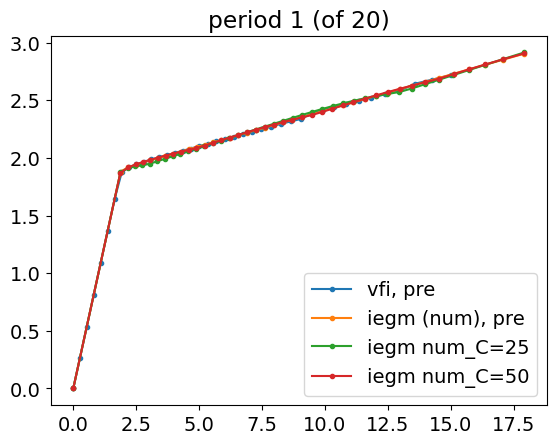

In [13]:
plot_names = ('vfi, pre','iegm (num), pre','iegm num_C=25','iegm num_C=50')
for t in (-20,):
    fig,ax = plt.subplots()
    for name in plot_names:
        m_interp = np.concatenate((np.array([0.0]),models[name].sol.M[t]))
        c_interp = np.concatenate((np.array([0.0]),models[name].sol.C[t]))
        ax.plot(m_interp,c_interp,label=name,marker='.')
        ax.legend();
        ax.set(title=f'period {models[name].par.T+t+1} (of {models[name].par.T})');

NameError: name 'model_specs_restricted' is not defined

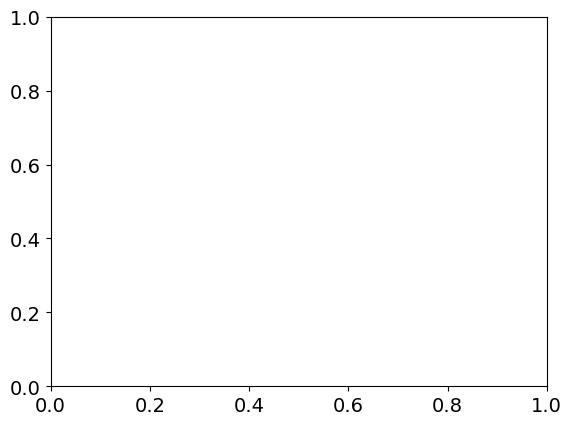

In [14]:
for t in (-5,-20):
    fig,ax = plt.subplots()
    for name,specs in model_specs_restricted.items():
        ax.scatter(models[name].sol.M[t,:],models[name].sol.C[t,:],label=name)
        ax.legend();
        ax.set(title=f'period {models[name].par.T+t+1} (of {models[name].par.T})');

In [ ]:
stop

In [ ]:
test_specs = {
    
    'num_m': 100,
    'num_C':50,
    
}


In [ ]:
# solve models with different approaches
models = dict()
for restricted in (True,False):
    restricted_str = 'unrestricted model' if not restricted else "restricted model"
    print(f'***** {restricted_str} *****')
    for method in ('vfi','egm','iegm'):
        for interp_method in ('linear',):
        # for interp_method in ('linear','numerical'):
            interp_str = ' num' if (interp_method=='numerical') & (method == 'iegm') else ''
            if (interp_method=='numerical') & (method != 'iegm'):
                continue
            for precomputed in (False,True):
                precomputed_str = '' if not precomputed  else ' (precomputed intra)'
                if (method=='egm') & (not restricted):
                    continue
                # if (method != 'iegm') & (precomputed):
                #     continue
                print(method+interp_str+precomputed_str)
                model_name = method+restricted_str+precomputed_str+interp_str
                models[model_name] = UnitaryModelClass(par={**test_specs,'method':method,'restricted_model':restricted,'precompute_intra':precomputed,'interp_method':interp_method})
                %time models[model_name].solve()
                print('\n',end='')

In [ ]:
# Q: why is the precompute_intra so important? Also for iEGM? is it the last-period and the calculation after finding Ctot in general?
# A: The use of the marginal utility in the Euler equation requires many re-calucations of the intra-temporal problem. Precomputing it is obious.
# But then what about the numerical EGM? Should that not pre-compute the marginal util?

# there is something happening with the interpolation over different grids. If I try to use the precomputed marginal_HH_util  and interpolate, then there is a problem elsewhere. Is it extrapolation that leads to negative marginal utility...?

In [ ]:
for restricted in (True,False):
    restricted_str = '' if not restricted else ", restricted"
    for t in (-5,-20):
        fig,ax = plt.subplots()
        for method in ('vfi','egm','iegm'):
            for interp_method in ('linear',):
            # for interp_method in ('linear','numerical'):
                interp_str = 'num' if (interp_method=='numerical') & (method == 'iegm') else ''
                if (interp_method=='numerical') & (method != 'iegm'):
                    continue
                for precomputed in (False,True):
                    precomputed_str = '' if not precomputed  else ' (precomputed)'
                    if (method=='egm') & (not restricted):
                        continue
                    if (method != 'iegm') & (precomputed):
                        continue
                    
                    model_name = method+restricted_str+precomputed_str+interp_str
                    ax.scatter(models[model_name].sol.M[t,:],models[model_name].sol.C[t,:],label=model_name+precomputed_str)
                    ax.legend();
                    ax.set(title=f'period {models[model_name].par.T+t+1} (of {models[model_name].par.T})'+restricted_str);

In [ ]:
stop
# all the monte carlo stuff is not implemented yet.

In [ ]:
# model_true = UnitaryModelClass({par=**true_specs'num_m:300})
# model_true.solve()

Monte Carlo Runs

In [ ]:
PRINT = False
# setup Monte Carlo results containers
timing = {
    'vfi':np.nan + np.zeros(MC_num),
    'egm':np.nan + np.zeros(MC_num),
    'egm, numerical':np.nan + np.zeros(MC_num),

    'iegm, linear':dict(),
    
}
mse = {
    'vfi':np.nan + np.zeros(MC_num),
    'egm':np.nan + np.zeros(MC_num),
    'egm, numerical':np.nan + np.zeros(MC_num),

    'iegm, linear':dict(),
}
util = {
    'vfi':np.nan + np.zeros(MC_num),
    'egm':np.nan + np.zeros(MC_num),
    'egm, numerical':np.nan + np.zeros(MC_num),
    
    'iegm, linear':dict(),
}
for i_c,num_C in enumerate(C_num_grid):
    timing['iegm, linear'][num_C] = np.nan + np.zeros(MC_num)
    mse['iegm, linear'][num_C] = np.nan + np.zeros(MC_num)
    util['iegm, linear'][num_C] = np.nan + np.zeros(MC_num)

# loop over Monte Carlo simulations
for i_mc in range(MC_num):
    if PRINT: print(f'{i_mc+1}/{MC_num} running...')
    # simulate true model (solved once above)
    model_true.par.seed = i_mc
    model_true.allocate()
    model_true.simulate()
    model_true.lifetime_utility(HH_util) 
    true_mean_lifetime_util = model_true.sim.mean_lifetime_util

    # setup alternative model solutios
    model = UnitaryModelClass(par=specs)
    model.par.seed = i_mc
    model.allocate()

    # VFI and EGM
    for method in ['vfi','egm']:
        model.par.method = method
        
        # Timing
        t0 = time()
        model.solve()
        timing[model.par.method][i_mc] = time() - t0

        # Accuracy
        model.simulate()
        mse[model.par.method][i_mc] = model.sim.mean_log10_euler
        util[model.par.method][i_mc] = np.abs((model.sim.mean_lifetime_util - true_mean_lifetime_util)/true_mean_lifetime_util) * 100

    # iEGM
    model.par.method = 'iegm'
    for interp_method in ('linear',):
        for interp_inverse in (False,True):
            model.par.interp_method = interp_method
            model.par.interp_inverse = interp_inverse
            method = f'{model.par.method}, {interp_method} inverse' if interp_inverse else f'{model.par.method}, {interp_method}'
            for i_c,num_C in enumerate(C_num_grid):
                model.par.num_C = num_C
                model.allocate()

                # Timing
                t0 = time()
                model.solve()
                timing[method][num_C][i_mc] = time() - t0

                # Accuracy
                model.simulate()
                mse[method][num_C][i_mc] = model.sim.mean_log10_euler
                util[method][num_C][i_mc] = np.abs((model.sim.mean_lifetime_util - true_mean_lifetime_util)/true_mean_lifetime_util) * 100

    model.par.interp_method = 'numerical'
    model.par.interp_inverse = False
    method = f'egm, {model.par.interp_method}'
    # Timing
    t0 = time()
    model.solve()
    timing[method][i_mc] = time() - t0

    # Accuracy
    model.simulate()
    mse[method][i_mc] = model.sim.mean_log10_euler
    util[method][i_mc] = np.abs((model.sim.mean_lifetime_util - true_mean_lifetime_util)/true_mean_lifetime_util) * 100


In [ ]:
print('lifetime util & Timing (rel. to VFI)')
timing_vfi = np.mean(timing['vfi'])
for method in ('vfi','egm','egm, numerical'):
    util_now = np.mean(util[method])
    time_now = np.mean(timing[method]) / timing_vfi
    print(f'{method}: {util_now:2.3f} & {time_now:2.3f} ')

for method in ('iegm, linear','iegm, linear inverse'):
    print(f'{method}: ')
    for i_c,num_C in enumerate(C_num_grid):
        util_now = np.mean(util[method][num_C]) 
        time_now = np.mean(timing[method][num_C]) / timing_vfi
        print(f'{num_C:d} {util_now:2.3f} & {time_now:2.3f} ')